# UB DataScience: Complex networks
### David Solans & Gerard Martinez

In [85]:

import networkx as nx
import matplotlib.pyplot as plt
from multiprocessing import Pool
import itertools
from networkx.algorithms import community
import collections
import numpy as np
import pickle
import operator
import folium

plt.style.use('seaborn')

%matplotlib inline

## Loading data

In [2]:
G_transport = nx.read_edgelist("barcelona_transport.edgelist", create_using = nx.Graph(), nodetype = int)
G_bus = nx.read_edgelist("barcelona_bus.edgelist", create_using = nx.Graph(), nodetype = int)
G_metro = nx.read_edgelist("barcelona_metro.edgelist", create_using = nx.Graph(), nodetype = int)

In [3]:
def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [4]:
#Quick snapshot of the Network
print(nx.info(G_transport))

Name: 
Type: Graph
Number of nodes: 2497
Number of edges: 3296
Average degree:   2.6400


In [6]:
# Average separation of nodes for transport graph
node_distances = []
for g in nx.connected_component_subgraphs(G_transport): 
    node_distances.append(nx.average_shortest_path_length(g)) 

    
print("Average separation of nodes: {}".format(np.mean(node_distances)))

Average separation of nodes: 8.72475195847366


In [7]:
#Quick snapshot of the Network
print(nx.info(G_bus))

Name: 
Type: Graph
Number of nodes: 2469
Number of edges: 3127
Average degree:   2.5330


In [8]:
# Average separation of nodes in metro
node_distances_metro = []
for g in nx.connected_component_subgraphs(G_metro): 
    node_distances_metro.append(nx.average_shortest_path_length(g)) 

    
print("Average separation of nodes in metro network: {}".format(np.mean(node_distances_metro)))

Average separation of nodes in metro network: 6.405542040656544


In [9]:
#Quick snapshot of the Network
print(nx.info(G_metro))

Name: 
Type: Graph
Number of nodes: 156
Number of edges: 169
Average degree:   2.1667


In [10]:
# Average separation of nodes in bus
node_distances_bus = []
for g in nx.connected_component_subgraphs(G_bus): 
    node_distances_bus.append(nx.average_shortest_path_length(g)) 

    
print("Average separation of nodes in bus network: {}".format(np.mean(node_distances_bus)))

Average separation of nodes in bus network: 9.731034826202404


### Selected network: BUS

We've selected the bus network because it's large enough and it's not conected to the metro network in the source where the data is obtained from

# --------- Week 1 --------- 

## 01: Matrices

### Exploratory Data Analysis

In [11]:
nodes = list(G_bus.nodes())

In [12]:
bus_stations_properties = load_obj("bus_stations_properties")

In [82]:
bus_stops_coords = []
bus_stops_names = []
bus_stops_coords_lats = []
bus_stops_coords_lngs = []
for bs in bus_stations_properties.values():
    bus_stops_coords.append([bs['lat'], bs['lon']])
    bus_stops_coords_lats.append(float(bs['lat']))
    bus_stops_coords_lngs.append(float(bs['lon']))
    bus_stops_names.append(bs['street_name'])

In [67]:
bus_stops_coords_lats[0]

41.3985182

In [84]:
bus_stops_names[:10]

['Almogàvers-Àvila',
 'Av Icària-Bogatell',
 'València-Muntaner',
 'Mallorca-Aribau',
 'Universitat Central',
 'Pl Universitat-Balmes',
 'Pl Universitat-Aribau',
 'Pl de Carles Buïgas',
 'Josep Soldevila - Doctor Santponç',
 'Josep Soldevila - Sant Adrià']

In [86]:
## Plotting the bus stops on a map
map_osm = folium.Map(location=[41.387084, 2.169792], zoom_start=12)
    
for lng, lat in zip(bus_stops_coords_lngs,
                         bus_stops_coords_lats):
    folium.Circle([lat, lng], radius=50).add_to(map_osm)
    
map_osm

In [115]:
bus_edges_list = []
for e in G_bus.edges():
    l = []
    if(e[0] in bus_stations_properties and e[1] in bus_stations_properties):
        l.append([float(bus_stations_properties[e[0]]['lat']), float(bus_stations_properties[e[0]]['lon'])])
        l.append([float(bus_stations_properties[e[1]]['lat']), float(bus_stations_properties[e[1]]['lon'])])
        bus_edges_list.append(l)
bus_edges_list[0]

[[41.3857139, 2.1946319], [41.3845874, 2.1954927]]

In [121]:
#Check: https://github.com/python-visualization/folium/blob/master/examples/Polyline_text_path.ipynb
map_osm = folium.Map(location=[41.387084, 2.169792], zoom_start=12)
 
"""    
for lng, lat in zip(bus_stops_coords_lngs,
                         bus_stops_coords_lats):
    folium.Circle([lat, lng], radius=50).add_to(map_osm)
"""
    

for e in bus_edges_list:
    folium.PolyLine(e,  weight=1).add_to(map_osm)
        
map_osm

In [16]:
#Auxiliary function to plot color categories
def plotNetwork(G, node_categories, colormap="jet", pos=None):
    plt.axis("off")
    if pos == None:
        pos = spring_pos = nx.spring_layout(G)
    nx.draw_networkx(G, pos = pos, cmap = plt.get_cmap(colormap), node_color = node_categories, node_size = 35, with_labels = False)

In [17]:
#Create network layout for visualizations
spring_pos = nx.spring_layout(G_bus)

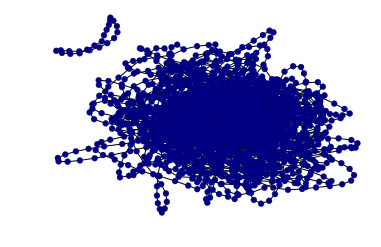

In [18]:
plotNetwork(G_bus, [0]*len(nodes),pos=spring_pos)

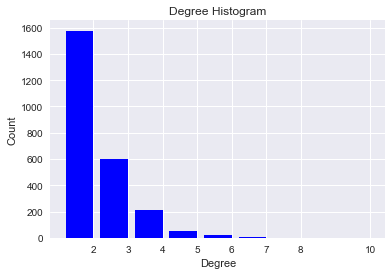

In [19]:
# Nodes degree histogram
degree_sequence = sorted([d for n, d in G_bus.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)
plt.show()

In [20]:
# Degree per node
nodes_degrees = [0]*len(nodes)
for idx, n in enumerate(nodes):
    nodes_degrees [idx] = G_bus.degree(n)

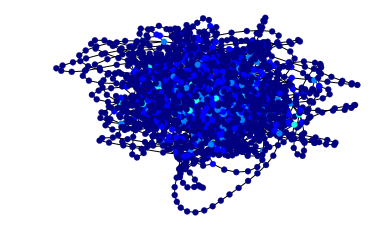

In [21]:
plotNetwork(G_bus, nodes_degrees)

### Adjacency matrix

In [22]:
adjacency_matrix = nx.adjacency_matrix(G_bus, nodelist=None, weight='weight')

Largest eigenvalue: 3.815050974028353
Smallest eigenvalue: -3.6549942785830756


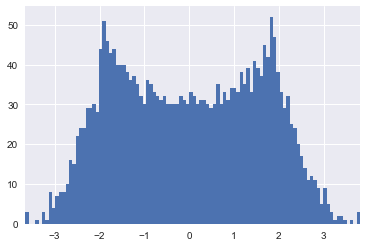

In [23]:
e = np.linalg.eigvals(adjacency_matrix.A)
print("Largest eigenvalue:", max(e))
print("Smallest eigenvalue:", min(e))
plt.hist(e, bins=100)  # histogram with 100 bins
plt.xlim(min(e), max(e))  # eigenvalues between min and max
plt.show()

## Laplacian matrix

Largest eigenvalue: 11.273333429855139
Smallest eigenvalue: 3.488998503407162e-15


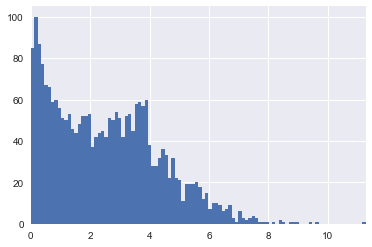

In [24]:
#laplacian_matrix = nx.laplacian_matrix(G_bus, nodelist=None, weight='weight')
#np.linalg.eig(laplacian_matrix.to_numpy_matrix())

laplacian_matrix = nx.laplacian_matrix(G_bus)
e = np.linalg.eigvals(laplacian_matrix.A)
print("Largest eigenvalue:", max(e))
print("Smallest eigenvalue:", min(e))
plt.hist(e, bins=100)  # histogram with 100 bins
plt.xlim(min(e), max(e))  # eigenvalues between min and max
plt.show()

### Centralities

In [25]:
#Degree centrality
degree_centrality = nx.degree_centrality(G_bus)

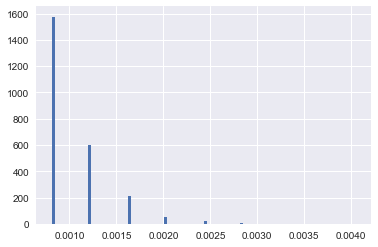

In [26]:
plt.hist(degree_centrality.values(), bins=100)  # histogram with 100 bins
plt.show()

In [27]:
max_degree_central_station = max(degree_centrality.items(), key=operator.itemgetter(1))
print(max_degree_central_station)
bus_stations_properties[max_degree_central_station[0]]

(777, 0.004051863857374392)


{'buses': '30 - 32 - 43 - 44 - 78 - 115',
 'city': 'BARCELONA',
 'furniture': 'Pal',
 'id': '777',
 'lat': '41.3805139',
 'lon': '2.1436483',
 'street_name': 'Av de Roma-Tarragona',
 'utm_x': '428486,2180',
 'utm_y': '4581552,6000'}

In [28]:
eigenvector_centrality = nx.eigenvector_centrality(G_bus, max_iter=10000, tol=1e-06, nstart=None, weight='weight')

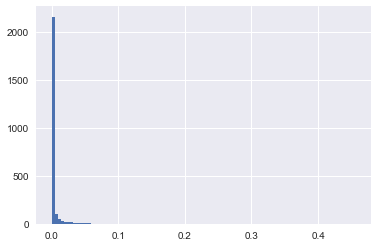

In [29]:
plt.hist(eigenvector_centrality.values(), bins=100)  # histogram with 100 bins
plt.show()

In [30]:
max_eigenvector_central_station = max(eigenvector_centrality.items(), key=operator.itemgetter(1))
print(max_eigenvector_central_station)
bus_stations_properties[max_eigenvector_central_station[0]]

(777, 0.456765123389888)


{'buses': '30 - 32 - 43 - 44 - 78 - 115',
 'city': 'BARCELONA',
 'furniture': 'Pal',
 'id': '777',
 'lat': '41.3805139',
 'lon': '2.1436483',
 'street_name': 'Av de Roma-Tarragona',
 'utm_x': '428486,2180',
 'utm_y': '4581552,6000'}

In [31]:
closeness_centrality = nx.closeness_centrality(G_bus)

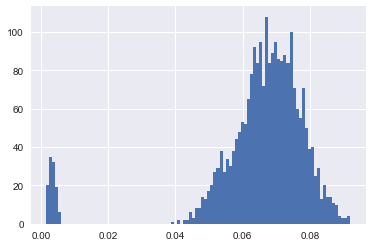

In [32]:
plt.hist(closeness_centrality.values(), bins=100)  # histogram with 100 bins
plt.show()

In [33]:
max_closeness_central_station = max(closeness_centrality.items(), key=operator.itemgetter(1))
print(max_closeness_central_station)
bus_stations_properties[max_closeness_central_station[0]]

(1209, 0.09206609595246185)


{'buses': '07 - 50 - 54 - 56 - 62 - 66 - 67 - 68',
 'city': 'BARCELONA',
 'furniture': 'Pal',
 'id': '1209',
 'lat': '41.3879730',
 'lon': '2.1664645',
 'street_name': 'Gran Via-Rambla Catalunya',
 'utm_x': '430401,3760',
 'utm_y': '4582362,7230'}

In [34]:
betweenness_centrality_source = nx.betweenness_centrality_source(G_bus)

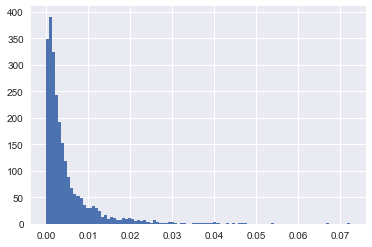

In [35]:
plt.hist(betweenness_centrality_source.values(), bins=100)  # histogram with 100 bins
plt.show()

In [36]:
max_betweeness_central_station = max(betweenness_centrality_source.items(), key=operator.itemgetter(1))
print(max_betweeness_central_station)
bus_stations_properties[max_betweeness_central_station[0]]

(21, 0.07239136501852589)


{'buses': '07 - 33 - 67 - 74 - 75 - 113 - L14 - N12 - L79',
 'city': 'BARCELONA',
 'furniture': 'Marquesina',
 'id': '21',
 'lat': '41.3856356',
 'lon': '2.1161664',
 'street_name': 'Av Diagonal-Palau Reial',
 'utm_x': '426194,0333',
 'utm_y': '4582144,2737'}

In [37]:
# Mirar relación entre medidas de centralidad. Esperamos que todo esté alrededor de la diagonal

# --------- Week 2 --------- 

## 02: Local characterization

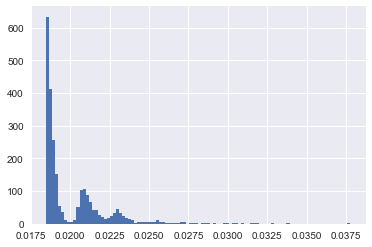

In [38]:
# Kantz centrality
kantx_centrality = nx.katz_centrality(G_bus)
plt.hist(kantx_centrality.values(), bins=100)  # histogram with 100 bins
plt.show()

In [39]:
# Comunicability
communicability = nx.communicability(G_bus)

KeyboardInterrupt: 

## 03 - Macroscale

In [40]:
# Mean shortest path
# Average separation of nodes in bus
# nx.average_shortest_path_length(G)

node_distances_bus = []
for g in nx.connected_component_subgraphs(G_bus): 
    node_distances_bus.append(nx.average_shortest_path_length(g)) 


print("Average separation per connected component: {}".format(node_distances_bus))
print("Average separation of nodes in bus network: {}".format(np.mean(node_distances_bus)))

Average separation per connected component: [14.307380464793308, 4.658008658008658, 10.227715355805243]
Average separation of nodes in bus network: 9.731034826202404


In [41]:
#Diameter
#nx.diameter(G)

node_diametres_bus = []
for g in nx.connected_component_subgraphs(G_bus): 
    node_diametres_bus.append(nx.diameter(g)) 

   
print("Diametre per connected component: {}".format(node_diametres_bus))
print("Average diameter in bus network: {}".format(np.mean(node_diametres_bus)))



Diametre per connected component: [36, 11, 25]
Average diameter in bus network: 24.0


In [ ]:
# To be sent:
    # Number nodes
    # Number links
    # Grado medio

#  --------- Others --------- 

## Community Detection

In [45]:
communities_generator = community.girvan_newman(G_bus)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
parts = sorted(map(sorted, next_level_communities))

In [46]:
node_communities = [0]*len(nodes)
for idx,c in enumerate(parts):
    for n in c:
        node_communities[nodes.index(n)] = idx
     

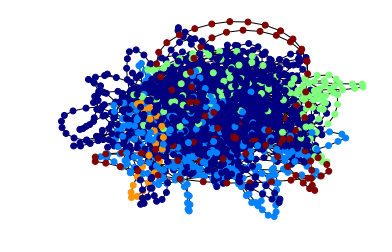

In [47]:
plotNetwork(G_bus,node_communities)

In [21]:
help(community)

Help on package networkx.algorithms.community in networkx.algorithms:

NAME
    networkx.algorithms.community - Functions for computing and measuring community structure.

DESCRIPTION
    The functions in this class are not imported into the top-level
    :mod:`networkx` namespace. You can access these functions by importing
    the :mod:`networkx.algorithms.community` module, then accessing the
    functions as attributes of ``community``. For example::
    
        >>> import networkx as nx
        >>> from networkx.algorithms import community
        >>> G = nx.barbell_graph(5, 1)
        >>> communities_generator = community.girvan_newman(G)
        >>> top_level_communities = next(communities_generator)
        >>> next_level_communities = next(communities_generator)
        >>> sorted(map(sorted, next_level_communities))
        [[0, 1, 2, 3, 4], [5], [6, 7, 8, 9, 10]]

PACKAGE CONTENTS
    asyn_fluidc
    centrality
    community_generators
    community_utils
    kclique
    ke